In [0]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist,cifar10
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import math
import numpy as np
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, BatchNormalization, Dropout, Input, Concatenate, AveragePooling2D,Flatten, Reshape, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers
from skimage.transform import resize
from tensorflow.keras.utils import to_categorical

In [0]:
choose_dataset = 1
choose_normalization = 2

if choose_dataset == 1:
  #Loading MNIST dataset
  (train_data,train_labels),(test_data,test_labels) = mnist.load_data()
  train_data = train_data.reshape((train_data.shape[0],28,28,1))
  test_data = test_data.reshape((test_data.shape[0],28,28,1))
else:
  #Loading CIFAR10 dataset
  (train_data,train_labels),(test_data,test_labels) = cifar10.load_data()

if choose_normalization == 1:
  #Scaling 1
  #Normalize to range of 0-1 
  train_data = train_data.astype('float32') /255.0
  test_data = test_data.astype('float32') / 255.0

else:
  #Scaling 2 Colab crashes
  #Standardization for zero mean and unit variance
  mean = train_data.mean()
  std_dev = train_data.std()

  train_data = train_data.astype('float32')
  test_data = test_data.astype('float32')
  train_data = (train_data-mean)/std_dev
  test_data = (test_data-mean)/std_dev

#One hot encode the numerical labels
train_labels = to_categorical(train_labels,num_classes=10)
test_labels = to_categorical(test_labels,num_classes=10) 

In [0]:
#Divide training data into training and validation
split = int(0.1*train_data.shape[0])
X_train = train_data[split:]
X_val = train_data[:split]
Y_train = train_labels[split:]
Y_val = train_labels[:split]

In [0]:
#MODEL 1
#Implementing GoogleNet Architecture
def inception_module(layer,num_filters):
  reduct_layer = Conv2D(filters=num_filters[0],kernel_size=(1,1),strides=1,padding='same',activation='relu')(layer)

  reduct_layer_conv_1 = Conv2D(filters=num_filters[1],kernel_size=(1,1),strides=1,padding='same',activation='relu')(layer)
  layer_conv_1 = Conv2D(filters=num_filters[2],kernel_size=(3,3),strides=1,padding='same',activation='relu')(reduct_layer_conv_1)

  reduct_layer_conv_2 = Conv2D(filters=num_filters[3],kernel_size=(1,1),strides=1,padding='same',activation='relu')(layer)
  layer_conv_2 = Conv2D(filters=num_filters[4],kernel_size=(5,5),strides=1,padding='same',activation='relu')(reduct_layer_conv_2)

  layer_maxpool = MaxPool2D(pool_size=(3,3),strides=1,padding='same')(layer)
  reduct_layer_maxpool = Conv2D(filters=num_filters[5],kernel_size=(1,1),strides=1,padding='same',activation='relu')(layer_maxpool)

  return Concatenate(axis=-1,)([reduct_layer,layer_conv_1,layer_conv_2,reduct_layer_maxpool])

def auxilliary_module(layer,layer_name):
  avg_layer = AveragePooling2D(pool_size=(5,5),strides=3,padding='same')(layer)

  reduct_layer = Conv2D(filters=128,kernel_size=(1,1),strides=1,padding='same',activation='relu')(avg_layer)
  reduct_layer = Flatten()(reduct_layer)

  fc_layer = Dense(units=1024,activation='relu')(reduct_layer)

  dropout_layer = Dropout(rate=0.70)(fc_layer)

  return Dense(units=10,activation='softmax',name=layer_name)(dropout_layer)


input_layer = Input(shape=(train_data.shape[1],train_data.shape[2],train_data.shape[3]))

#resize_layer = Lambda(lambda x: tf.image.resize(x,(224,224)))(input_layer)

conv1_layer = Conv2D(filters=64,kernel_size=(7,7),padding='same',activation='relu',strides=2)(input_layer)
maxpool1_layer = MaxPool2D(pool_size=(3,3),strides=2,padding='same')(conv1_layer)
norm1_layer = BatchNormalization()(maxpool1_layer)

conv2reduct_layer = Conv2D(filters=64,kernel_size=(1,1),strides=1,padding='same',activation='relu')(norm1_layer)
conv2_layer = Conv2D(filters=192,kernel_size=(3,3),strides=1,padding='same',activation='relu')(conv2reduct_layer)
norm2_layer = BatchNormalization()(conv2_layer)
maxpool2_layer = MaxPool2D(pool_size=(3,3),strides=2,padding='same')(norm2_layer)

inception3a_layer = inception_module(maxpool2_layer,[64,96,128,16,32,32])
inception3b_layer = inception_module(inception3a_layer,[128,128,192,32,96,64])

maxpool3_layer =  MaxPool2D(pool_size=(3,3),strides=2,padding='same')(inception3b_layer)

inception4a_layer = inception_module(maxpool3_layer,[192, 96, 208, 16, 48, 64])
aux1_layer = auxilliary_module(inception4a_layer,'aux1')
inception4b_layer = inception_module(inception4a_layer,[160, 112, 224, 24, 64, 64])
inception4c_layer = inception_module(inception4b_layer,[128, 128, 256, 24, 64, 64])
inception4d_layer = inception_module(inception4c_layer,[112, 144, 288, 32, 64, 64])
aux2_layer = auxilliary_module(inception4d_layer,'aux2')
inception4e_layer = inception_module(inception4d_layer,[256, 160, 320, 32, 128, 128])

maxpool4_layer =  MaxPool2D(pool_size=(3,3),strides=2,padding='same')(inception4e_layer)

inception5a_layer = inception_module(maxpool4_layer,[256, 160, 320, 32, 128, 128])
inception5b_layer = inception_module(inception5a_layer,[384, 192, 384, 48, 128, 128])

avg_layer = AveragePooling2D(pool_size=(7,7),strides=1,padding='same')(inception5b_layer)
avg_layer = Flatten()(avg_layer)

dropout_layer = Dropout(rate=0.4)(avg_layer)

output_layer = Dense(units=10,activation='softmax',name='output')(dropout_layer)

model = Model(inputs=input_layer,outputs=[output_layer,aux1_layer,aux2_layer])
model.compile(optimizer=optimizers.SGD(learning_rate=0.01,momentum=0.9),
              metrics=['accuracy'],
              loss='categorical_crossentropy')
model.summary()

In [0]:
training_history = []

In [10]:
history = model.fit(x=X_train,
                    y=[Y_train,Y_train,Y_train],
                    validation_data=(X_val,[Y_val,Y_val,Y_val]),
                    epochs=5,
                    batch_size=256
                    )
training_history.append(history)

Epoch 1/5
211/211 [==============================] - 31s 146ms/step - loss: 0.0562 - output_loss: 0.0191 - aux1_loss: 0.0181 - aux2_loss: 0.0190 - output_accuracy: 0.9945 - aux1_accuracy: 0.9948 - aux2_accuracy: 0.9946 - val_loss: 0.1146 - val_output_loss: 0.0385 - val_aux1_loss: 0.0367 - val_aux2_loss: 0.0395 - val_output_accuracy: 0.9907 - val_aux1_accuracy: 0.9902 - val_aux2_accuracy: 0.9900
Epoch 2/5
211/211 [==============================] - 31s 146ms/step - loss: 0.0370 - output_loss: 0.0120 - aux1_loss: 0.0122 - aux2_loss: 0.0129 - output_accuracy: 0.9965 - aux1_accuracy: 0.9965 - aux2_accuracy: 0.9964 - val_loss: 0.1445 - val_output_loss: 0.0489 - val_aux1_loss: 0.0454 - val_aux2_loss: 0.0503 - val_output_accuracy: 0.9863 - val_aux1_accuracy: 0.9873 - val_aux2_accuracy: 0.9862
Epoch 3/5
211/211 [==============================] - 31s 146ms/step - loss: 0.0380 - output_loss: 0.0125 - aux1_loss: 0.0121 - aux2_loss: 0.0133 - output_accuracy: 0.9963 - aux1_accuracy: 0.9965 - aux2_ac

In [0]:
#Training with data augmentation
datagen = ImageDataGenerator(horizontal_flip=True,width_shift_range=0.2,height_shift_range=0.2)
datagen.fit(X_train)

In [27]:
batch_size=256
history = model.fit_generator(datagen.flow(X_train,Y_train,batch_size=batch_size),
                              steps_per_epoch=math.ceil(X_train.shape[0]/batch_size),
                              validation_data=(X_val,Y_val),
                              epochs=20)
training_history.append(history)

Epoch 1/20
176/176 [==============================] - 37s 209ms/step - loss: 1.1046 - output_loss: 0.3651 - aux1_loss: 0.3704 - aux2_loss: 0.3691 - output_accuracy: 0.8731 - aux1_accuracy: 0.8712 - aux2_accuracy: 0.8714 - val_loss: 1.5546 - val_output_loss: 0.5170 - val_aux1_loss: 0.5166 - val_aux2_loss: 0.5209 - val_output_accuracy: 0.8326 - val_aux1_accuracy: 0.8340 - val_aux2_accuracy: 0.8336
Epoch 2/20
176/176 [==============================] - 37s 208ms/step - loss: 1.0982 - output_loss: 0.3634 - aux1_loss: 0.3676 - aux2_loss: 0.3673 - output_accuracy: 0.8739 - aux1_accuracy: 0.8729 - aux2_accuracy: 0.8729 - val_loss: 1.5725 - val_output_loss: 0.5232 - val_aux1_loss: 0.5204 - val_aux2_loss: 0.5288 - val_output_accuracy: 0.8204 - val_aux1_accuracy: 0.8222 - val_aux2_accuracy: 0.8212
Epoch 3/20
176/176 [==============================] - 37s 209ms/step - loss: 1.0833 - output_loss: 0.3581 - aux1_loss: 0.3624 - aux2_loss: 0.3628 - output_accuracy: 0.8737 - aux1_accuracy: 0.8725 - aux2

In [0]:
#Saving model
model.save('GoogleNetCIFAR.h5')

In [11]:
model.evaluate(test_data,[test_labels,test_labels,test_labels],batch_size=256,verbose=1)

40/40 [==============================] - 1s 32ms/step - loss: 0.1094 - output_loss: 0.0360 - aux1_loss: 0.0353 - aux2_loss: 0.0381 - output_accuracy: 0.9911 - aux1_accuracy: 0.9915 - aux2_accuracy: 0.9912


[0.10944739729166031,
 0.0359991118311882,
 0.0353437177836895,
 0.03810456395149231,
 0.991100013256073,
 0.9915000200271606,
 0.9911999702453613]

In [0]:
#Plotting for GoogleNet
import matplotlib.pyplot as plt
import matplotlib

train_accuracy = []
validation_accuracy = []
validation_loss = []
output_loss = []
aux1_loss = []
aux2_loss = []
for i in training_history:
  aux1_loss += i.history['aux1_loss']
  aux2_loss += i.history['aux2_loss']
  output_loss += i.history['output_loss']
  train_accuracy += i.history['output_accuracy']
  validation_accuracy += i.history['val_output_accuracy']

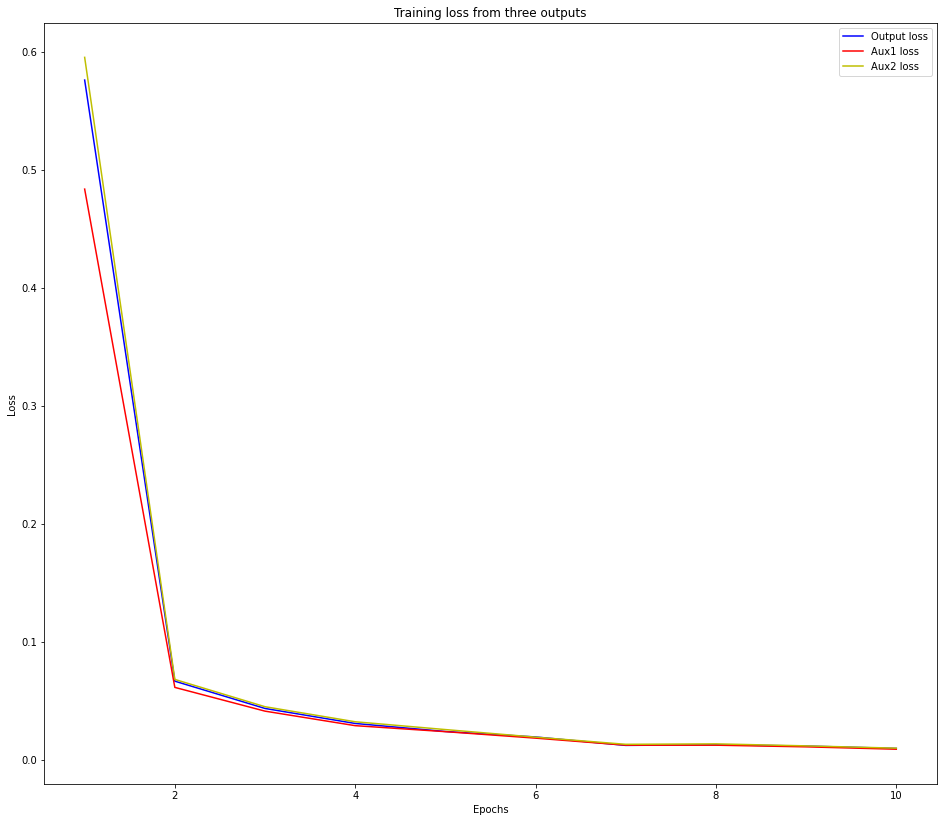

In [13]:
#Plot Training losses for output,aux1 output and aux2 output
matplotlib.rcParams['figure.figsize'] = [16.0,14.0]
epochs = range(1, len(train_accuracy) + 1)

plt.plot(epochs, output_loss, 'b', label='Output loss')
plt.plot(epochs, aux1_loss, 'r', label='Aux1 loss')
plt.plot(epochs, aux2_loss, 'y', label='Aux2 loss')
plt.title('Training loss from three outputs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('GoogleNetMNISTLoss.png')
plt.show()

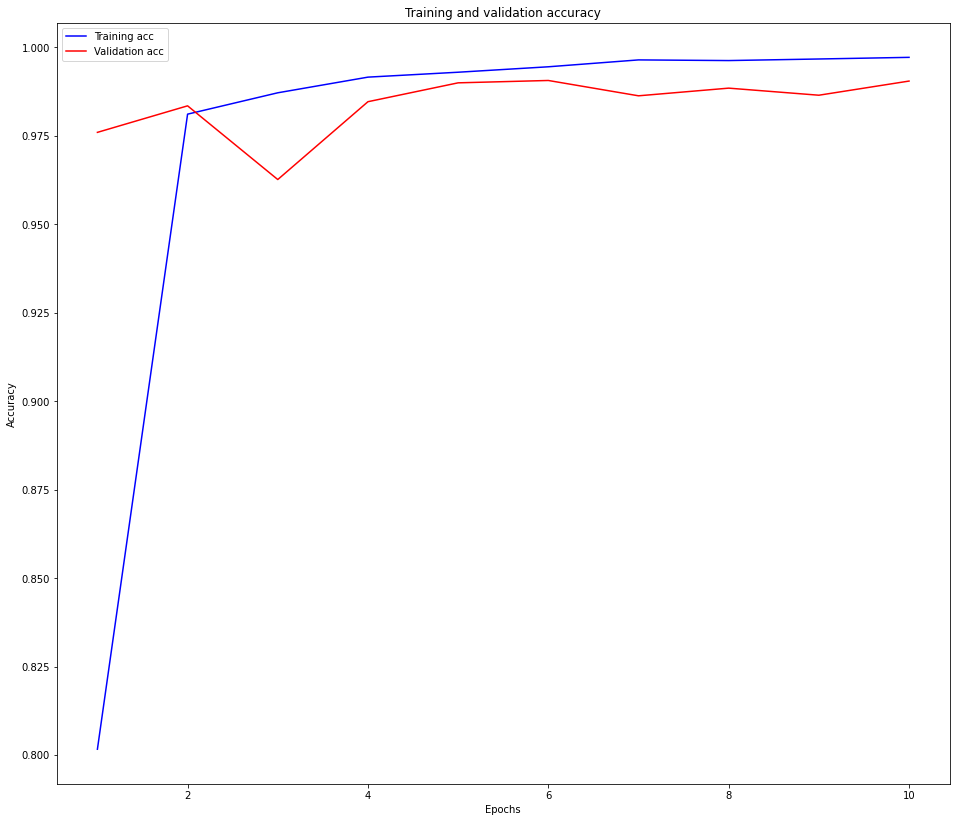

In [14]:
#Plot train and validation accuracy
matplotlib.rcParams['figure.figsize'] = [16.0,14.0]
epochs = range(1, len(train_accuracy) + 1)

plt.plot(epochs, train_accuracy, 'b', label='Training acc')
plt.plot(epochs, validation_accuracy, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.savefig('GoogleNetMNISTAccuracy.png')
plt.show()